# Lab 2: The NV Centre in Diamond - Optically Detected Magnetic Resonance (ODMR)
#### Setup B

Press Shift+Enter to run each code segment. The raw data generated by this notebook can be found in the folder './data/{todays_date}/'.

## Review Exercises

### Q1. Review the figures below. For each figure, in words, explain whether you expect the output signal on the lock-in amplifier to be low (i.e. background noise), or high. 

#### Case 1.
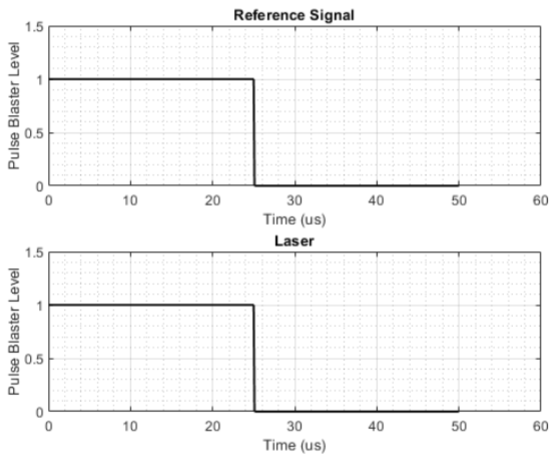

#### Case 2.
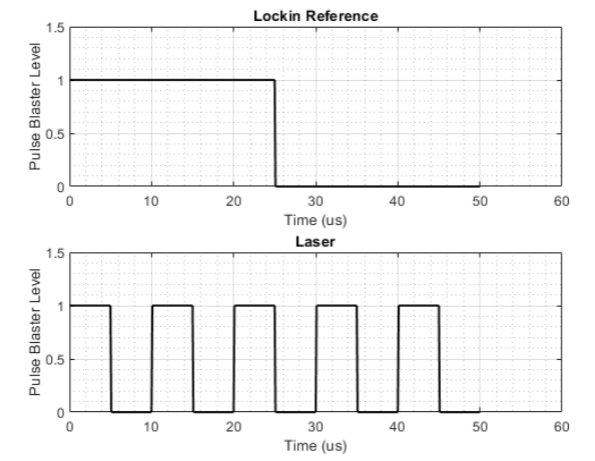

### Q2.  Review the figure below. In words, explain whether you expect the output signal on the lock-in namplifier to be low (i.e. background noise), or high, under each of the following conditions: a) The microwave output is off, b) The microwave output is on at 1 GHz, c) The microwave output is on at 2.87 GHz.

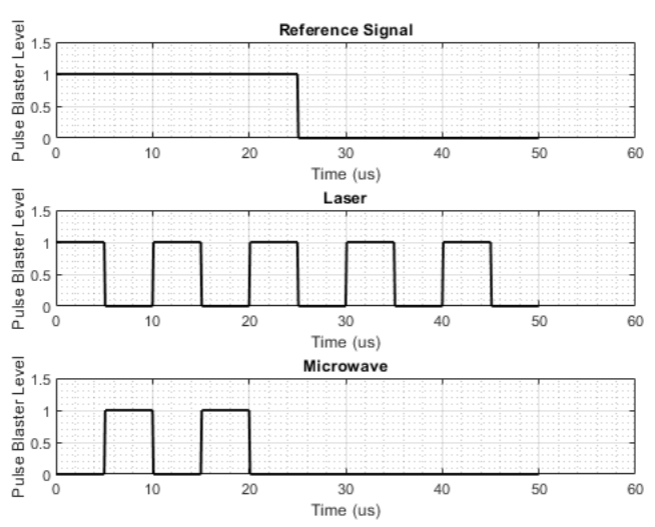


In [ ]:
%matplotlib widget

import qcodes as qc
import qcodes.utils.validators as vals
from qcodes.plots.qcmatplotlib import MatPlot
from qcodes.loops import Loop
from qcodes.data.data_set import load_data
from qcodes.actions import Task, Wait
from qcodes.measure import Measure
from qcodes.utils import magic

from ultolib import (anritsu, korad, spincore)
from ultolib.spincore import pulse
import qcodes.instrument_drivers.stanford_research.SR830 as stanford_research

from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

Connect the computer to the instruments. 

##### Only run this code segment ONCE! 
Otherwise, to connect to the instruments again, the kernel (i.e. the python backend) must be restarted and any unsaved data will be lost.

In [ ]:
pulse_blaster = spincore.PulseBlasterESRPRO(name='pulse_blaster', board_number=0)
pulse_blaster.core_clock(300)                     #Sets the clock speed, 
                                                  #must be called immediately after connecting to the PulseBlaster
lock_in_amp = stanford_research.SR830(name='lock_in_amp', address='GPIB0::13::INSTR')
microwave_src = anritsu.MG3681A('microwave_src', 'GPIB0::3::INSTR')
microwave_src.output('OFF')
microwave_src.output_level_unit('dBm')
microwave_src.pulse_modulation('OFF')
dc_supply = korad.KD3305P('dc_supply', 'ASRL4::INSTR')
dc_supply.ch1.voltage_setpoint(0)
dc_supply.ch1.current_setpoint(0)

station=qc.Station(pulse_blaster, lock_in_amp, microwave_src)
loc_provider = qc.data.location.FormatLocation(fmt='data/{date}/#{counter}_{name}_{time}')
qc.data.data_set.DataSet.location_provider = loc_provider

## Task 2.1: Optically Detected Magnetic Resonance

In the previous lab, we had performed an experiment to measure the optically detected magnetic resonance at zero magnetic field. In this task, we shall apply a DC magnetic field to the diamond sample and observe what happens to the resonance peaks.

The coils of the electromagnet are driven by a DC power supply that can be programmed through Matlab.  The magnetic field produced by the coils is proportional to the currentpassing through the wires, and so one can easily convert between current and magnetic fieldstrength using a scaling factor. This scaling factor is called the coil constant and usually given in units of Tesla per Ampere [T/A].

For this task, we shall measure the ODMR spectra for various values of applied coil current. Program the pulse blaster with the appropriate pulse sequence to obtain an ODMR spectra. In the cell below fill out the missing values that define the required pulse sequence (hint: recall the pulse sequence used in the previous lab).

In [ ]:
ref_f = 200                                  #Reference frequency.
ref_D = 0.5                                  #Reference duty cycle.
T_ref_on = ref_D * 1 / ref_f                 #Reference time on.
T_ref_off = (1 - ref_D) * 1 / ref_f          #Reference time off.

#TODO: Specify these constants.
laser_f = 100e3                              #Laser modulation frequency.
laser_D = 0.5                                #Laser modulation duty cycle.
T_laser_on =                                 #Laser time on. 
T_laser_off =                                #Laser time off.
N_laser_pulses =                             #Number of laser pulses that can fit in the reference period.

mw_f = laser_f                               #Microwave modulation frequency.
mw_D = laser_D                               #Microwave modulation duty cycle.
T_mw_on =                                    #Microwave time on.
T_mw_off =                                   #Microwave time off.
N_mw_pulses =                                #Number of microwave pulses that can fit in the reference period.

Now construct the pulse sequence, using the values defined above.

In [ ]:
pulse_blaster.reset_channel_buffer()  #Clear the previous pulse sequence.
pulse_blaster.ch0.pulse_sequence_buffer.set(
    #TODO: Enter the lock in reference pulse sequence.
)                                     #Define the new pulse sequence for channel 0.
pulse_blaster.ch1.pulse_sequence_buffer.set( 
    #TODO: Enter the laser pulse sequence.
)                                     #Define the new pulse sequence for channel 1.
pulse_blaster.ch2.pulse_sequence_buffer.set(
    #TODO: Enter the microwave modulation pulse sequence.
)                                     #Define the new pulse sequence for channel 2.
pulse_blaster.plot_channel_buffer()   #This function plots the newly defined pulse sequence.
pulse_blaster.flush_channel_buffer()

Run the experiment.

In [ ]:
#Lock-in amplifier settings
lock_in_amp.time_constant(100e-3)
lock_in_amp.sensitivity(50e-6)
#Microwave source settings
microwave_src.power(0)
microwave_src.frequency(2.65e9)
microwave_src.pulse_modulation('EXT')
microwave_src.output('ON')
#DC power supply settings
dc_supply.ch1.voltage_setpoint(12)

In [ ]:
loop = Loop(dc_supply.ch1.current_setpoint.sweep(0, 0.5, step=0.05)).loop(
            microwave_src.frequency.sweep(2.65e9, 3e9, num=226),
            delay=5*lock_in_amp.time_constant()).each(lock_in_amp.R)
#Plot the measurement
data_ODMR = loop.get_data_set(name='ODMR')
plot = MatPlot(data_ODMR.lock_in_amp_R, cmap='viridis')
plot.tight_layout()
for l in loop:
    l.with_bg_task(plot.update)

In [ ]:
#Run the measurement
loop.run()
plot.update()

The measurement in this task will take some time, you can work on Task 2.2 in the meantime.

### Q3. Carefully note the various salient features of the ODMR spectra. How many resonance peakscan be observed? How many do we expect to see? Do all the resonance peaks react to achange in coil current amplitude in the same way?

## Task 2.2: Simulating ODMR using the NV Hamiltonian

As was pointed out in the first lab and is shown in Fig. 6, The NV center in diamond can be oriented in four unique directions with respect to the crystal axis. Each orientation of the NV center experiences a different effective magnetic field. Thus, the direction of the applied magnetic field may have a significant effect on the ODMR spectra we wish to observe. In this task, we would like to simulate the NV center’s Hamiltonian in order to figure out the orientation of the magnetic field produced by the coils with respect to the sample. 

Before we begine the simulation, we must define:

1. The spin gyromagnetic ratio ('g_e') and zero-field splitting ('D').
2. The spin-1 operators ('S').
3. The primitive vectors of a face-centre cubic lattice ('e').
4. The NV axis vectors ('NV_axis').

In [ ]:
g_e = 28e9
D = 2.87e9

S = {'x': [], 'y': [], 'z': []}
S['x'] = np.array([[             0,    1/np.sqrt(2),              0],
                   [  1/np.sqrt(2),               0,   1/np.sqrt(2)],
                   [              0,   1/np.sqrt(2),              0]])

S['y'] = np.array([[              0, -1j/np.sqrt(2),              0],
                   [  1j/np.sqrt(2),              0, -1j/np.sqrt(2)],
                   [              0,  1j/np.sqrt(2),              0]])

S['z'] = np.array([[              1,              0,              0],
                   [              0,              0,              0],
                   [              0,              0,             -1]])

e = {'x': np.array([1, 0, 0]),
     'y': np.array([0, 1, 0]),
     'z': np.array([0, 0, 1])}

NV_axis = np.array([[ 1,  1,  1],
                    [-1, -1,  1],
                    [-1,  1, -1],
                    [ 1, -1, -1]])
NV_axis = [axis / np.linalg.norm(axis) for axis in NV_axis]
NV_comp = {key: [np.dot(axis, e[key]) for axis in NV_axis] for key in e}

For this task adjust the direction of the magnetic field vector ('u') and the coil constant ('coil_constant') (the scaling factor that allows you to convert from current to magnetic field) in the code until the ODMR spectra ‘map’ matches that of the experimental result. Starting values have been provided for you.

In [ ]:
coil_constant = 0.03   # in T/A originally 0.012
u = [1,0.5,0.0]

We are now ready to begin the simulation. In the below code segment, the Hamiltonian for an NV centre of each orientation is computed; for different static magnetic fields; and the energy eigenvalues are evaluated. From this the NV centre resonance lines can be computed. Run the code below to perform the calculation.

In [ ]:
u = np.array(u)
u = u / np.linalg.norm(u)

current = np.linspace(0, 0.5, num=50)
B0 = coil_constant * current
B = {key: np.dot(u, e[key]) for key in e}

diff_eigs = []
for b0 in B0:
    H=np.ndarray((4, 3, 3), dtype=complex)
    for i in range(0, 4):
        H[i] = D * np.linalg.matrix_power(sum([NV_comp[key][i] * S[key] for key in e]), 2) + \
               g_e * b0 * sum([B[key] * S[key] for key in e])
    eigs = [np.linalg.eig(H[i])[0] for i in range(0, 4)]
    eigs = [np.sort(ev) for ev in eigs]
    diff_eigs.append([[np.real(ev[1]-ev[0]), np.real(ev[2]-ev[0])] for ev in eigs])
diff_eigs = np.array(diff_eigs)

fig, ax = plt.subplots()
for i in range(0,4):
    for j in range(0,2):
        ax.plot(current, diff_eigs[:, i, j]);
ax.set_ylim([2.65e9, 3e9]);
ax.set_xlabel('Current (A)');
ax.set_ylabel('Frequency (Hz)');

We now wish to add the data you have measured, to plot above to check whether it agrees with the experiment. Run the code segment below if Task 2.1 has been completed and you wish to use the data just measured. Note this will only work on the lab PC. 

In [ ]:
data_ODMR_2D_fit = data_ODMR

Or load the data from the data files by completing and running the code below. 

##### If you have run the previous code segment do not run the following (or vice-versa).

In [ ]:
data_ODMR_2D_fit = load_data('Enter the data path here!')

Add the experimental data to the above plot.

In [ ]:
x = data_ODMR_2D_fit.dc_supply_ch1_current_setpoint_set.ravel()
y = data_ODMR_2D_fit.microwave_src_frequency_set.ravel()
z = data_ODMR_2D_fit.lock_in_amp_R.ravel()
y = y[0: int(len(y) / len(x))]
X, Y = np.meshgrid(x, y)
Z = [[z[i * (len(y)-1) + j] for j in range(0, len(y))] for i in range(0, len(x))]
Z = np.transpose(Z)

ax.pcolormesh(x, y, Z, shading='auto', cmap='Blues')
fig.canvas.draw_idle()

## Task 2.3: The Hyperfine Splitting

The negatively charged vacancy in the NV center couples to the spin of its 14N nuclei which is a non-zero spin system. This will lead to further splitting of the electronic energy levels, known as hyperfine splitting.

For this task set the magnetic field to 0.005 T. 

Note: For this task, Task 2.2 must have been completed and the coil_constant determined.

In [ ]:
dc_supply.ch1.voltage_setpoint(12)
B0 = 0.005
I0 = B0/coil_constant
assert I0 < 0.5, "Set I0 to be less than 0.5 A."
dc_supply.ch1.current_setpoint(I0)
print('The applied current is {:.3f} A.'.format(I0))

Perform an ODMR experiment to find the resonance peak at the highest frequency. Ensure that the coil current is not so high that the resonance of the peak exceeds 3 GHz. If that is the case, lower the B0 in the above code cell. You can consult your ODMR map to get an idea about the frequency range. For this ODMR peak, we will perform a high resolution ODMR scan centered around the chosen peak. Enter the values for the minimum and maximum frequencies to be scanned in the spectrum, below. Initially, it may help to scan a larger range in order to locqate the peak and then tighten the range to get a better scan.

Repeat this experiment for microwave powers 9 dbm, 6 dBm and -3 dB. You may have to increase the lock-in amplifier time constant at -3 dBm.

Note: This experiments uses the pulse sequence from Task 2.1. If you are doing the tasks in order then you can run the code segment below. However, if this task is being done after Task 2.4 or you are unsure whether the pulse sequence is correct re-run the first two code segments of Task 2.1 prior to the following code sequence.

**The microwave frequency must be $\leq 3$ GHz.**

In [ ]:
microwave_src.power(9)             #Repeat for 6 and -3.
microwave_src.output('ON')

lock_in_amp.sensitivity(100e-6)
lock_in_amp.time_constant(100e-3)

#TODO: Enter the ODMR frequency range.
min_frequency =                   #Minimum frequency for the spectrum
max_frequency =                   #Maximum frequency for the spectrum,
                                  #Must not be > 3 GHz.

loop = Loop(microwave_src.frequency.sweep(min_frequency, max_frequency, num=200),
            delay=5*lock_in_amp.time_constant()).each(lock_in_amp.R)
#Plot the measurement
data_ODMR_2D = loop.get_data_set(name='ODMR_Hyperfine')
plot = MatPlot(data_ODMR_2D.lock_in_amp_R)
plot.tight_layout()
loop.with_bg_task(plot.update)

In [ ]:
#Run the measurement
loop.run()
plot.update()

After completeing this task, you may want to plot the data to compare the spectra. See Appendix B on how to access and plot your data. 

### Q4. Observe and note down all the salient features of the ODMR spectra. How many peaks do you observe? How far apart are the peaks from each other? Would you expect these peaks to move further apart when the magnetic field is increased? Can you guess the spin quantum number of the 14N nuclei that the vacancy is coupled to based on the number of peaks youcan observe?

### Q5. What effect did reducing the microwave power have on the ODMR spectra?

# Task 2.4: Coherent Control and Rabi Oscillations

For this task, we shall choose one of the many resonance frequencies that were observed in the ODMR spectra at a suitable magnetic field. Similar to the ODMR experiment, the microwave source will need to be programmed to output an oscillating signal with the chosen resonance frequency. Enter the resonance frequency below, choose the peak with the lowest frequency.

In [ ]:
microwave_src.frequency(#Enter the resonance frequency here.)

When the resonant microwave radiation is applied, the NV center’s spin will rotate for th eduration of the applied microwave radiation at a frequency that is dependent on the intensity of the microwave power. This rotation can be measured as an oscillation of the measured photoluminescence intensity. This oscillation is known as a Rabi oscillation.

So far, we do not know how long the microwave field must be applied to an NV center in order to rotate the spin fully from |0〉to |±1〉. In this experiment, we shall incrementally increase the width of the microwave pulses and measure the resulting signal using the lock-in amplifier, in order to find out the following parameters:

1. The microwave $\pi$ pulse duration.
2. The frequency of the oscillating signal caused by the NV centre's spin.
3. The decay time of the oscillation.

To tell python that we wish to sweep the microwave pulse length, we need to define two sweepable parameters: the microwave on time (T_mw_on) and the microwave off time (T_mw_off). We do so below along with defining the the other pulse sequence parameters such as, laser on time and the reference frequency.

In [ ]:
ref_f = 200                                  #Reference frequency.
ref_D = 0.5                                  #Reference duty cycle.
T_ref_on = ref_D * 1 / ref_f                 #Reference time on.
T_ref_off = (1 - ref_D) * 1 / ref_f          #Reference time off.

laser_f = 100e3                              #Laser modulation frequency.
laser_D = 0.5                                #Laser modulation duty cycle.
T_laser_on = laser_D * 1 / laser_f           #Laser time on. 
T_laser_off = (1 - laser_D) * 1 / laser_f    #Laser time off.
N_laser_pulses = round(laser_f / ref_f)      #Number of laser pulses that can fit in the reference period.

mw_f = laser_f                               #Microwave modulation frequency.
T_mw_on = qc.ManualParameter('T_mw_on',      #Microwave on time.
                             label='tau', initial_value=20e-9, unit='s')
def get_T_mw_off():
    return T_laser_on + T_laser_off - T_mw_on()
T_mw_off = qc.Parameter('T_mw_off',          #Microwave off time.
                        get_cmd=get_T_mw_off, unit='s')
N_mw_pulses = int(ref_D * N_laser_pulses)    #Number of microwave pulses that can fit in the reference period.


Use the pre-defined microwave on and off times to write the pulse sequence required to measure Rabi oscillations.

In [ ]:
pulse_blaster.reset_channel_buffer()  #Clear the previous pulse sequence.
pulse_blaster.ch0.pulse_sequence_buffer.set(
    #TODO: Enter the lock in reference frequency pulse sequence here.
)                                     #Define the new pulse sequence for channel 0.
pulse_blaster.ch1.pulse_sequence_buffer.set(
    #TODO: Enter the laser pulse sequence here.
)                                     #Define the new pulse sequence for channel 1.
pulse_blaster.ch2.pulse_sequence_buffer.set(
    #TODO: Enter the microwave modulation pulse sequence here.
)                                     #Define the new pulse sequence for channel 2.
pulse_blaster.plot_channel_buffer()   #This function plots the newly defined pulse sequence.
pulse_blaster.flush_channel_buffer()

Set the microwave power to 15 dBm. You will repeat this measurement for microwave powers of 12 dBm, 9 dBm, and 6 dBm.

In [ ]:
microwave_src.power(15)

Now set the instruments to correct experimental parameters and run the experiment. Remember to check that your magnetic field is set to the correct value. You can do so by running the first code segment in Task 2.3.

In [ ]:
lock_in_amp.time_constant(3)
lock_in_amp.sensitivity(100e-6)

microwave_src.output('ON')

loop = Loop(T_mw_on.sweep(80e-9, 4e-6, step=80e-9)).each(
    Task(pulse_blaster.flush_channel_buffer),
    Wait(5 * lock_in_amp.time_constant()),
    lock_in_amp.R
)
#Plot the measurement
data_Rabi = loop.get_data_set(name='Rabi')
plot = MatPlot(data_Rabi.lock_in_amp_R)
plot.tight_layout()
loop.with_bg_task(plot.update)

In [ ]:
#Run the measurement
loop.run()
plot.update()

We are interested in measuring the Rabi frequency and to do so, we must fit the data to a decaying sinusoid of the form:

$ae^{-t/T} sin{(2 \pi f_R \tau+\phi)}+c$

First we must define the fit model and perform the fit. Choose appropriate initial parameters to fit the measured data to.

In [ ]:
#TODO: Enter the initial fit params
initial_fit_params = #[a, T, f_R, phi, c]
def fit_model(x, a, b, f, p ,c):
    return a * np.exp(-1.0 * x / b) * np.sin(2 * np.pi * f * x + p) + c

Run the below code segment if you wish to fit the just measured data.

In [ ]:
data_Rabi_to_fit = data_Rabi

Otherwise, complete and run the code segment below to load previously saved data.

In [ ]:
data_Rabi_to_fit = load_data('Enter your data path here')
MatPlot(data_Rabi_to_fit.lock_in_amp_R)

Now run the code below to perform the fit.

In [ ]:
xdata = data_Rabi_to_fit.T_mw_on_set.ravel()
ydata = data_Rabi_to_fit.lock_in_amp_R.ravel()
fit_params, fit_cov = curve_fit(fit_model, xdata, ydata, initial_fit_params)

Now create a dummy experiment to save the fit.

In [ ]:
fit_Rabi_freq = qc.ManualParameter(name='fit_Rabi_freq', unit='Hz', initial_value=fit_params[2])
fit_Rabi_freq_err = qc.ManualParameter(name='fit_Rabi_freq_err', unit='Hz', initial_value=np.sqrt(fit_cov[2][2]))
meas_Rabi_freq = Measure(fit_Rabi_freq, fit_Rabi_freq_err)
data_Rabi_freq_params = meas_Rabi_freq.get_data_set(name='Rabi_fit_params')
meas_Rabi_freq.run()

R_fit = qc.ManualParameter(name='R_fit', unit='V')
def set_fit_curve(ax_val):
    R_fit.set(fit_model(ax_val, *fit_params))   
tau_fit = qc.Parameter(name='tau_fit', label='tau', 
                        unit='s', set_cmd=set_fit_curve)

loop = Loop(tau_fit.sweep(xdata.min(), xdata.max(), num=100)).each(R_fit)
data_Rabi_fit = loop.get_data_set(name='T1_fit')
loop.run()
plot = MatPlot([data_Rabi_to_fit.lock_in_amp_R, data_Rabi_fit.R_fit])

In [ ]:
print('The Rabi frequency is = {:.1f} +/- {:.1f} kHz'.format(fit_Rabi_freq() / 1e3, fit_Rabi_freq_err() / 1e3))

Repeat the measurement for microwave powers of 12 dBm, 9 dBm, and 6 dBm.

#### Q5. Do you observe any relationship between the microwave power and the oscillation frequency of the signal? By how much must the microwave source be attenuated for the Rabi frequency to be changed by a factor of 2? Furthermore, are the oscillations completely sinusoidal at lower powers? Explain why this could be the case.

### Turn off the instruments

In [ ]:
pulse_blaster.stop()
microwave_src.output('OFF')
dc_supply.ch1.voltage_setpoint(0)
dc_supply.ch1.current_setpoint(0)

## Appendix A: Installing QCoDeS

This lab uses the open-source qcodes library to manage experimental data. To work on this lab at home, you will need to install Python >3.7 and qcodes. 

Qcodes can be installed by running the command:

or in anaconda:

For futher information, visit: https://qcodes.github.io/Qcodes/start/index.html

## Appendix B: Accessing Your Data

You may run a measurement many times - let's say 5 times - and decide that the third run is the measurement you would like to plot for your lab report. Or you would like to access the data to perform some analysis. Unfortunately, the notebook is showing the latest run, run 5. Thus, you must be able to import your data into the notebook. Thankfully qcodes provides a method to load saved data. To use it first it must be imported as follows.

In [ ]:
from qcodes.data.data_set import load_data

This can be done by calling the function 'load_data' the data location as the argument. The data location for each experiment, is saved in a directory formatted as ./data/YYYY-MM-DD/#{Three-digit experiment id}_{Experiement name}_hh_mm_ss'. This location is also figure title for any experiments run. For example:

In [ ]:
from qcodes.plots.qcmatplotlib import MatPlot
test_data1 = load_data('./data/2021-09-20/#001_test_data1_13-13-07')
test_data2 = load_data('./data/2021-09-20/#002_test_data2_13-13-50')

In [ ]:
test_data1

You can then plot the data by calling the function 'MatPlot' as shown below. When using 'Matplot', multiple dataset may be plotted. If supplied in the argument list as Matplot(dataset1, dataset2, ...), 'MatPlot' will create subplots with each dataset plotted within its own subplot. If the datasets are supplied as Matplot([dataset1, dataset2, ...]), the datasets will be plotted on the same axis.

In [ ]:
MatPlot([test_data1.y, test_data2.y])

Convert the data into a numpy array for data processing or curve fitting can be done so by calling the 'reval' method of the parameter you would like to convert in the data set. Remember to add the '_set' suffix if the paramter was swept. 

In [ ]:
test_data1.x_set.ravel()
test_data1.y.ravel()